In [1]:
import faiss
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import random
from glob import glob

In [2]:
with open("../data/f30k_descriptors2.pkl", "rb") as f:
    files = pickle.load(f)

for file in files:
    file["path"] = str(Path("../data/f30k") / f"{file['filename']}.jpg")

print(f"Loaded {len(files)} descriptors arrays")
print(f"Total number of SIFT descriptors: {sum([len(f['descriptors']['sift']) for f in files])}")
print(f"Total number of ORB descriptors: {sum([len(f['descriptors']['orb']) for f in files])}")

Loaded 31784 descriptors arrays
Total number of SIFT descriptors: 3183244
Total number of ORB descriptors: 3176142


In [3]:
descriptors_sift = np.concatenate([f['descriptors']["sift"] for f in files if f['descriptors'] is not None], axis=0).astype(np.float32)
descriptors_orb = np.concatenate([f['descriptors']["orb"] for f in files if f['descriptors'] is not None], axis=0).astype(np.float32)

In [18]:
kmeans_sift = faiss.Kmeans(descriptors_sift.shape[1],
                      200,
                      niter=300,
                      nredo=1,
                      verbose=True,
                      gpu=True)
kmeans_sift.train(descriptors_sift)
print(kmeans_sift.centroids.shape)

Sampling a subset of 51200 / 3183244 for training
Clustering 51200 points in 128D to 200 clusters, redo 1 times, 300 iterations
  Preprocessing in 0.31 s
(200, 128)n 299 (2.98 s, search 2.05 s): objective=3.63475e+09 imbalance=1.069 nsplit=0       



In [19]:
kmeans_orb = faiss.Kmeans(descriptors_orb.shape[1],
                      90,
                      niter=300,
                      nredo=1,
                      verbose=True,
                      gpu=True)
kmeans_orb.train(descriptors_orb)
print(kmeans_orb.centroids.shape)

Sampling a subset of 23040 / 3176142 for training
Clustering 23040 points in 32D to 90 clusters, redo 1 times, 300 iterations
  Preprocessing in 0.14 s
  Iteration 299 (0.76 s, search 0.36 s): objective=2.3576e+09 imbalance=1.026 nsplit=0        
(90, 32)


In [20]:
for file in files:
    D, I = kmeans_sift.index.search(file['descriptors']['sift'].astype(np.float32), 1)
    word_idx = I.flatten();
    bow = np.bincount(word_idx.ravel(), minlength=kmeans_sift.centroids.shape[0])
    # normalized = bow / np.linalg.norm(bow)
    file['bow_sift'] = bow

In [21]:
for file in files:
    D, I = kmeans_orb.index.search(file['descriptors']['orb'].astype(np.float32), 1)
    word_idx = I.flatten();
    bow = np.bincount(word_idx.ravel(), minlength=kmeans_orb.centroids.shape[0])
    # normalized = bow / np.linalg.norm(bow)
    file['bow_orb'] = bow

In [22]:
for file in files:
    file['bow'] = np.concatenate([file['bow_sift'], file['bow_orb']], axis=0)

In [23]:
df = np.zeros(kmeans_sift.centroids.shape[0] + kmeans_orb.centroids.shape[0], dtype=np.float32)
for file in files:
    for i in range(len(file['bow'])):
        df[i] += file['bow'][i] > 0

df = df / len(files)

for file in files:
    term_frequencies = file['bow'] / np.linalg.norm(file['bow'])
    file['tfidf'] = term_frequencies * np.log(1 / df)

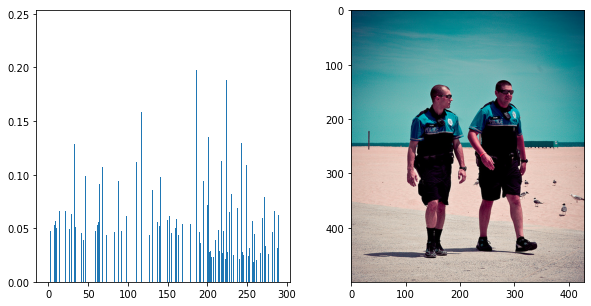

In [24]:
random_file = random.choice(files)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax2.imshow(cv2.cvtColor(cv2.imread(random_file["path"]), cv2.COLOR_BGR2RGB))
ax1.bar(range(len(random_file['tfidf'])), random_file['tfidf'])
plt.show()

In [25]:
def chi_square(x, y):
    return 0.5 * np.sum((x - y) ** 2 / (x + y + 1e-10))

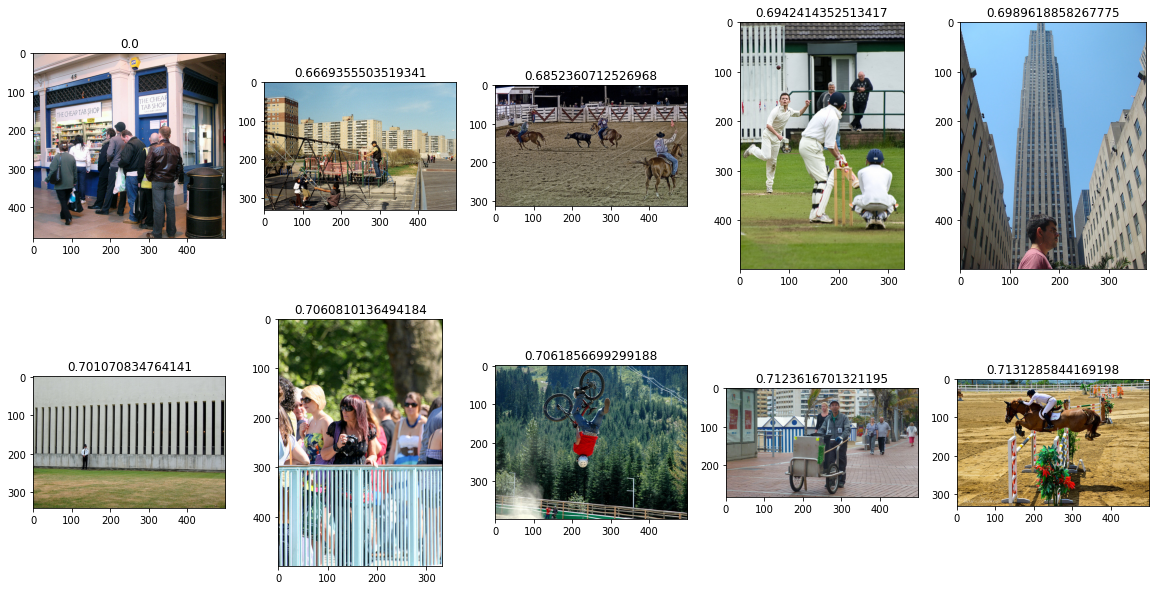

In [99]:
import scipy.spatial.distance as metrics
distances = []
random_file = random.choice(files)

for file in files:
    distance = metrics.correlation(random_file['tfidf'], file['tfidf'])
    distances.append({
        'path': file["path"],
        'distance': distance
    })

distances = sorted(distances, key=lambda x: x['distance'], reverse=False)

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(5):
    axs[0][i].imshow(cv2.cvtColor(cv2.imread(distances[i]['path']), cv2.COLOR_BGR2RGB))
    axs[0][i].set_title(distances[i]['distance'])
    axs[1][i].imshow(cv2.cvtColor(cv2.imread(distances[5+i]['path']), cv2.COLOR_BGR2RGB))
    axs[1][i].set_title(distances[5+i]['distance'])


In [89]:
# construct a faiss index from all the tfidf vectors
index = faiss.IndexFlatIP(kmeans_sift.centroids.shape[0] + kmeans_orb.centroids.shape[0])
index.add(np.array([f['tfidf'] / np.linalg.norm(f['tfidf']) for f in files]).astype(np.float32))

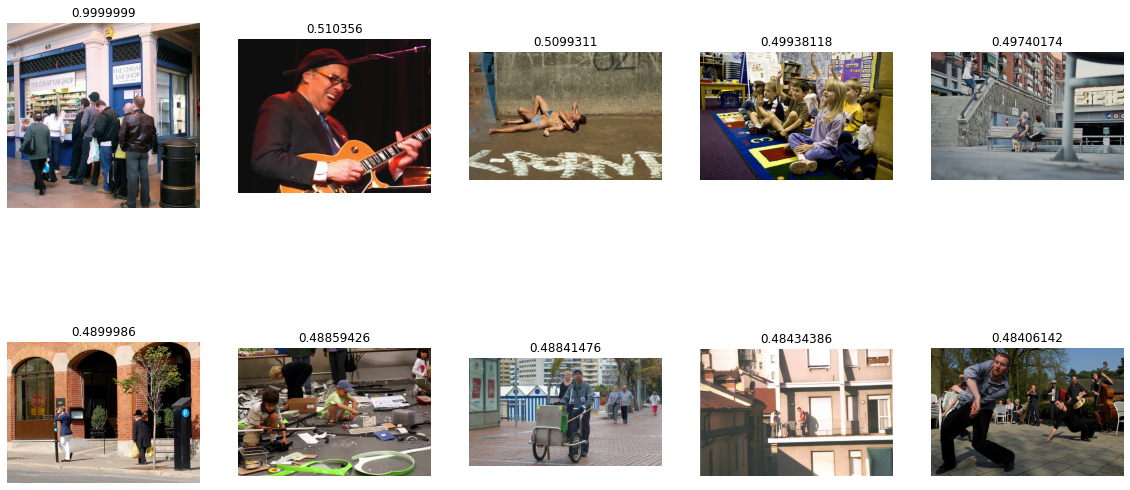

In [100]:
#random_file = random.choice(files)

normalized = random_file['tfidf'] / np.linalg.norm(random_file['tfidf'])
D, I = index.search(np.array([normalized]).astype(np.float32), 10)

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(5):
    axs[0][i].imshow(cv2.cvtColor(cv2.imread(files[I[0][i]]['path']), cv2.COLOR_BGR2RGB))
    axs[0][i].set_title(D[0][i])
    axs[0][i].axis('off')
    axs[1][i].imshow(cv2.cvtColor(cv2.imread(files[I[0][i + 5]]['path']), cv2.COLOR_BGR2RGB))
    axs[1][i].set_title(D[0][i + 5])
    axs[1][i].axis('off')
plt.show()